<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/2_Convoluciones/Capas_Convolucionales.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>


# Ejemplo Motivacional

Supongamos que queremos generar un sistema que reconozca números escritos a mano. Una forma de hacerlo es contar la cantidad de formas simples que existen dentro del número y verificar a cuál número corresponde su conteo en la siguiente tabla.

![texto del enlace](https://blog.ovhcloud.com/wp-content/uploads/2019/02/IMG_0067.jpg)

De esta manera, dado un número nuevo, simplemente deberemos contar la cantidad de formas que aparecen en él para predecir su valor.

![texto del enlace](https://blog.ovhcloud.com/wp-content/uploads/2019/02/IMG_0069-768x693.jpg)

El problema con este método es cómo determinar si una forma está presente en la imagen. Esto es posible si pensamos en las imágenes como matrices. Cada celda de la matriz representa la intensidad del píxel desde 0 (que representa el negro) hasta 255 (que representa un píxel blanco puro).

![texto del enlace](https://blog.ovhcloud.com/wp-content/uploads/2020/06/1_cLsTCWtUL1GYBUv8vnbOxw.jpeg)

Para descubrir qué patrón se muestra en una imagen (en este caso el 8 escrito a mano) usaremos una especie de scanner. En el aprendizaje automático, estos scanners se llaman filtros. El filtro se utiliza para realizar un cálculo de convolución de matrices clásico. Esta operación dará como resultado un número alto si el patrón definido en el filtro se parece al sector de la imagen escaneado, sino dará un número bajo.

![texto del enlace](https://iq.opengenus.org/content/images/2020/05/OptKernelMatrice.png)



En la figura de arriba imaginemos que la matriz verde es un imagen con un cuadrado negro en el centro (los ceros son pixeles negros) rodeado por un borde blanco (los unos con pixeles blancos)y luego por otro borde negro. La matriz amarilla representa un filtro que es un cuadrado blanco de 3x3. Al escanear la imagen con el filtro nos tirará para cada pixel un valor que nos dirá qué tanto se parece ese sector de 3x3 a un cuadrado blanco.

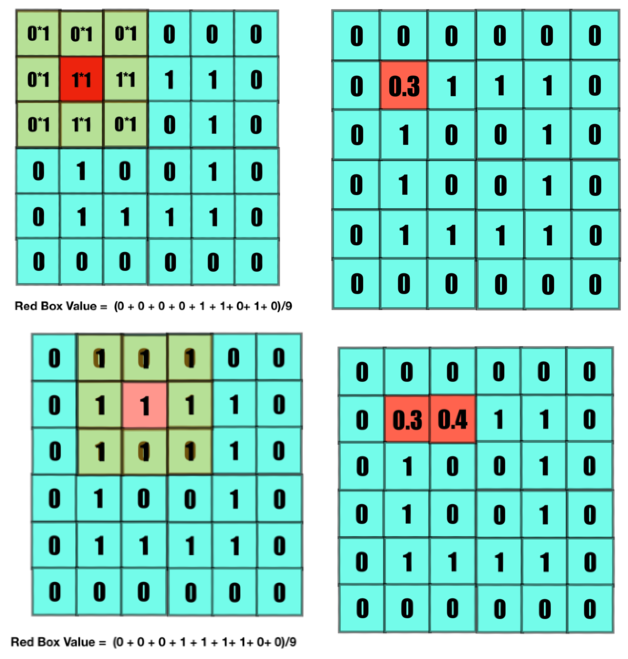

Luego de haber escaneado la imagen completa obtendremos un resultado como este.

![](https://iq.opengenus.org/content/images/2020/05/OptConvolve5.png)

Pero ¿qué pasa con las esquinas? Aquí necesitamos **Padding** (relleno). El padding prácticamente extiende la matriz para atender los valores del borde como se describe en la imagen a continuación. La capa rosa no forma parte de la matriz originals, pero ayuda en la convolución.
En el siguiente ejemplo, el relleno se toma como 0.

![](https://iq.opengenus.org/content/images/2020/05/OptConvolve6.png)

El resultado final es el siguiente.

![](https://iq.opengenus.org/content/images/2020/05/OptConvolve7.png)

Podemos interpretar la salida del filtro como otra imagen donde los valores más blancos indican sectores más parecidos al patrón del filtro.

![](https://iq.opengenus.org/content/images/2020/05/MeanTransf.png)

Así como hicimos un filtro que detecte cuadrado9s blancos, podemos diseñar filtros que detecten las formas que necesitamos para reconocer los números o cualquier otra forma. Más aun, podríamos entrenar una red para que **aprenda qué filtros necesita detectar para reconocer los números** en lugar de tener que estar diseñándolos nosotros.

# Redes neuronales convolucionales.

En la sección anterior vimos las convoluciones eran una herramienta muy útil en procesamiento de imágenes. La gran utilidad que tienen estas herramientas eventualmente dio lugar a crear eventualmente a las redes neuronales convolucionales. La diferencia entre estas redes y los MLP que habíamos visto anteriormente es que aquí los parametro  a ser aprendidos son los kernels que realizan las convoluciones.

Veamos un ejemplo de esto empezando con un ejemplo de una cuadricula de $3 \times 3$ a la que le aplicamos un kernel de $ \times 2$


![](http://d2l.ai/_images/correlation.svg)


Analicemos como hemos llegado al tamaño final

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Tenga en cuenta que a lo largo de cada eje, el tamaño de salida es ligeramente más pequeño que el tamaño de entrada. Debido a que el kernel tiene ancho y alto mayor que uno, solo podemos calcular correctamente la convolución para ubicaciones donde el kernel encaja completamente dentro de la imagen, el tamaño de salida viene dado por el tamaño de entrada $n_h \times n_w$ menos el tamaño del kernel de convolución $k_h \times k_w$ a través de

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

Este es el caso ya que necesitamos suficiente espacio para "mover" el kernel de convolución a través de la imagen. Más adelante veremos cómo mantener el tamaño sin cambios. rellenando la imagen con ceros alrededor de su borde para que haya suficiente espacio para el kernel. A continuación, implementamos este proceso en la función `corr2d`, que acepta un tensor de entrada `X` y un tensor kernel `K` y devuelve un tensor de salida `Y`.

In [ ]:
import torch
from torch import nn

In [ ]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # producto de Haddamar
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Capas convolucionales

Una capa convolucional aplica la función anterior y un sesgo escalar para producir una salida. Los dos parámetros de una capa convolucional
son el núcleo y el sesgo escalar. Al entrenar modelos basados en capas convolucionales, normalmente inicializamos los núcleos al azar, tal como lo haríamos con una capa completamente conectada.

Ahora estamos listos para implementar una capa convolucional bidimensional basado en la función `corr2d` definida anteriormente. En el método constructor `__init__`, declaramos `weight` y `bias` como los dos parámetros del modelo. La función de propagación directa
llama a la función `corr2d` y agrega el sesgo.


In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## Primer ejemplo: Detector de bordes verticales.

Tomemos un momento para analizar una aplicación simple de una capa convolucional:
detectar el borde de un objeto en una imagen. Para ellos buscamos la ubicación del cambio de píxel.
Primero, construimos una "imagen" de $6\times 8$ píxeles.
Las cuatro columnas del medio son negras (0) y el resto son blancas (1).

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

A continuación, construimos un núcleo `K` con una altura de 1 y un ancho de 2. Cuando realizamos al aplicar la convolución,
si los elementos adyacentes horizontalmente son iguales,
la salida es 0. De lo contrario, la salida es distinta de cero.
Tenga en cuenta que este kernel es un caso especial de un operador de diferencias finitas. En la ubicación $(i,j)$ calcula $x_{i,j} - x_{(i+1),j}$, es decir, calcula la diferencia entre los valores de los píxeles adyacentes horizontalmente. Esta es una aproximación discreta de la primera derivada en la dirección horizontal.


In [ ]:
K = torch.tensor([[1.0, -1.0]])

Estamos listos para realizar una convolución con argumentos `X` (nuestra entrada) y `K` (nuestro kernel). Como puede ver, detectamos 1 para el borde de blanco a negro y -1 para el borde de negro a blanco. Todas las demás salidas toman valor 0.

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Al aplicar el kernel transpuesto obtenemos ceros. La versión **transpuesta** del kernel detecta bordes verticales y nuestra imagen no los tiene


In [ ]:
X.t()

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [ ]:
corr2d(X.t(), K.t())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

## Aprendiendo un kernel

Diseñar un detector de bordes por diferencias finitas `[1, -1]` puede ser útil si sabemos que esto es precisamente lo que estamos buscando. Sin embargo, a medida que observamos núcleos más grandes, y considerar capas sucesivas de convoluciones, puede ser imposible especificar
precisamente lo que cada filtro debe hacer manualmente.

Ahora veamos si podemos aprender el núcleo que generó `Y` a partir de `X` mirando solo los pares de entrada-salida. Primero construimos una capa convolucional e inicializa su kernel como un tensor aleatorio. A continuación, en cada iteración, usaremos el error al cuadrado para comparar `Y` con la salida de la capa convolucional. Luego podemos calcular el gradiente para actualizar el kernel. Por el bien de la simplicidad,
en el siguiente usamos la clase incorporada para capas convolucionales bidimensionales e ignorar el sesgo.


In [ ]:
# Constructor de la clase convolucion bidimensional de torch.
# Hemos apagado a los bias. El kernel es de la forma (1,2)
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# La capa convolucional de dos dimensiones usa entrada  y salidas de cuatro
# dimensiones y en el formato de (ejemplo, canal, alto, ancho). Para este
# ejemplo el tamaño de lote (número de ejemplos en el lote)
# y el número de canales son ambos 1

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2 ## minimos cuadrados
    conv2d.zero_grad()
    l.sum().backward()
    # actualizamos los pesos
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 1.098
epoch 4, loss 0.184
epoch 6, loss 0.031
epoch 8, loss 0.005
epoch 10, loss 0.001


Tras 10 iteraciones tenemos una buena aproximación al kernel esperado.

In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9949, -0.9942]])

## Correlación cruzada y convoluciones.


Hasta aquí hemos hablado de convoluciones, pero en realidad hay una diferencia entre nuestra operación y una convolución propiamente dicha. La operación que realizamos es en realidad una correlación cruzada. ¿Qué pasaría si estas capas realizaran operaciones de convolución estrictas en lugar de correlaciones cruzadas? Para obtener el resultado de la operación de *convolución* estricta, solo necesitamos voltear el tensor kernel bidimensional tanto horizontal como verticalmente, y luego realizar la operación de *correlación cruzada* con el tensor de entrada.

Cabe señalar que, dado que los núcleos se aprenden a partir de datos en el aprendizaje, las salidas de las capas convolucionales no se ven afectadas no importa si llevamos a cabo convoluciones estrictas o las operaciones de correlación cruzada.

De acuerdo con la terminología estándar con la literatura de aprendizaje profundo, seguiremos refiriéndonos a la operación de correlación cruzada
como una convolución aunque, estrictamente hablando, es ligeramente diferente. Además, usamos el término *elemento* para referirnos a una entrada (o componente) de cualquier tensor que represente una representación de capa o un núcleo de convolución.


## Mapa de características y Campo receptivo.

La salida de la capa convolucional a veces se llama un **mapa de características**, pues son representaciones aprendidas (características) en las dimensiones espaciales (por ejemplo, ancho y alto) que se alimentan a la capa subsiguiente. En las CNN, para cualquier elemento $x$ de alguna capa, su **campo receptivo** se refiere a todos los elementos (de todas las capas anteriores) que puede afectar el cálculo de $x$ durante la propagación directa. Tenga en cuenta que el campo receptivo puede ser mayor que el tamaño real de la entrada.

Sigamos usando la figura anterior para explicar el campo receptivo.

![](http://d2l.ai/_images/correlation.svg)

Dado el kernel o núcleo de convolución $2 \times 2$, el campo receptivo del elemento de salida sombreado (de valor $19$) es los cuatro elementos en la parte sombreada de la entrada. Ahora vamos a denotar la salida de forma $2 \times 2$ como $\mathbf{Y}$ y considere una CNN más profunda con una capa convolucional adicional de $2 \times 2$ que toma $\mathbf{Y}$ como su entrada, salida un solo elemento $z$. En este caso, el campo receptivo de $z$ en $\mathbf{Y}$ incluye los cuatro elementos de $\mathbf{Y}$, mientras que el campo receptivo en la entrada original incluye los nueve elementos de entrada. De este modo, cuando un elemento en un mapa de características necesita un campo receptivo más grande podemos construir una red más profunda.

Los campos receptivos derivan su nombre de la neurofisiología. En una serie de experimentos en una variedad de animales y diferentes estímulos, Hubel y Wiesel exploraron la respuesta de la corteza visual sobre dichos estímulos. En general encontraron que los niveles inferiores responden a los bordes y  formas relacionadas. Posteriormente, se ilustró este efecto sobre la naturaleza imágenes con, lo que solo se puede llamar, núcleos convolucionales.


Resulta que esta relación incluso es válida para las características calculadas por capas más profundas de redes entrenadas en tareas de clasificación de imágenes.  Baste decir que las circunvoluciones han demostrado ser una herramienta increíblemente poderosa para la visión por computadora, tanto en biología como en código. Como tal, no sorprende (en retrospectiva) que anunciaran el éxito reciente en el aprendizaje profundo.

# Padding y Stride

Volvamos a la figura anterior.

![](http://d2l.ai/_images/correlation.svg)

La entrada tenía una altura y un ancho de 3 y el núcleo de convolución tenía una altura y un ancho de 2, produciendo una representación de salida con dimensión $2\times2$. Dijimos que para una entrada  la forma $n_h\times n_w$ y kernel de la forma $k_h\times k_w$, la forma de salida será $(n_h-k_h+1) \times (n_w-k_w+1)$. Solo podemos mover el kernel hasta que se agote los píxeles a los que aplicar la convolución.

A continuación exploraremos una serie de técnicas, incluyendo relleno y convoluciones con strides o trancos, que ofrecen más control sobre el tamaño de la salida. Como motivación, tenga en cuenta que dado que los núcleos generalmente tienen ancho y alto mayor que $1$, después de aplicar muchas convoluciones sucesivas, tendemos a terminar con resultados que son
considerablemente más pequeño que nuestra entrada. Si comenzamos con una imagen de $240 \times 240$ píxeles, tras $10$ capas de $5 \times 5$ convoluciones, la imágen se recude a $200 \times 200$ píxeles, cortando $30 \%$ de la imagen y con ella borrando cualquier información interesante
en los límites de la imagen original. **Padding** o agregar relleno es la herramienta más popular para manejar este problema. En otros casos, podemos querer reducir la dimensionalidad drásticamente, por ejemplo, si encontramos que la resolución de entrada original es difícil de manejar. Las **convoluciones con strides o trancos** son una técnica popular que puede ayudar en estos casos.

## Padding

Como se describió anteriormente, un problema al aplicar capas convolucionales es que tendemos a perder píxeles en el perímetro de nuestra imagen. Considere la próxima imagen que representa la utilización de píxeles como una función del tamaño del kernel de convolución y la posición dentro de la imagen. Los píxeles de las esquinas apenas se utilizan.

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-reuse.svg?raw=1)

Dado que normalmente usamos núcleos pequeños, para cualquier convolución dada, es posible que solo perdamos unos pocos píxeles. Pero el número de píxeles crece a medida que aplicamos muchas capas convolucionales sucesivas Una solución directa a este problema es agregar píxeles adicionales de relleno alrededor del límite de nuestra imagen de entrada, aumentando así el tamaño efectivo de la imagen. Por lo general, establecemos los valores de los píxeles adicionales en cero. En la siguiente imágen rellenamos una entrada de $3 \times 3$, aumentando su tamaño a $5 \times 5$. La salida correspondiente luego aumenta a una matriz de $4 \times 4$. Las partes sombreadas son el primer elemento de salida, así como los elementos de entrada y de kernel utilizados para el cálculo de salida:

$$0\times0+0\times1+0\times2+0\times3=0$$.

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-pad.svg?raw=1)


En general, si agregamos $p_h$ filas de relleno  (mitad arriba, mitad abajo)
 y $p_w$ columnas de relleno (mitad a la izqueirda, mitad a al derecha),
la salida será:

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

Esto significa que la altura y el ancho de la salida aumentará en $p_h$ y $p_w$, respectivamente.

En muchos casos, querremos configurar $p_h=k_h-1$ y $p_w=k_w-1$ para dar a la entrada y salida la misma altura y anchura. Esto facilitará la predicción de la forma de salida de cada capa al construir la red. Asumiendo que $k_h$ es impar aquí, rellenaremos $p_h/2$ filas en ambos lados de la altura. Si $k_h$ es par, una posibilidad es pad $\lceil p_h/2\rceil$ filas en la parte superior de la entrada y $\lfloor p_h/2\rfloor$ filas en la parte inferior. Rellenaremos ambos lados del ancho de la misma manera.

Las CNN suelen utilizar núcleos de convolución con valores impares de alto y ancho, como 1, 3, 5 o 7. Elegir tamaños de kernel impares tiene la ventaja
que podemos preservar la dimensionalidad mientras rellena con el mismo número de filas en la parte superior e inferior, y el mismo número de columnas a izquierda y derecha.

Además, esta práctica de usar núcleos impares y padding para preservar con precisión la dimensionalidad ofrece un beneficio adicional. Para cualquier tensor bidimensional `X`, cuando el tamaño del núcleo es impar: *
  * el número de filas y columnas de relleno por los bordes son iguales
  * la salida tiene la misma forma entrada
  * el campo receptivo de la salida `Y[i, j]` se calcula con una ventana centrada en `X[i, j]` a partir del kernel

En el siguiente ejemplo, creamos una capa convolucional bidimensional
con un kernel de altura y ancho igual a 3. Además agregamos 1 píxel de relleno en todos los bordes. Dada una entrada con una altura y un ancho de 8, encontramos que la altura y el ancho de la salida también es 8.


In [ ]:
import torch
from torch import nn


# Definimos una función auxiliar para calcular convoluciones. Se inicializan
# los pesos de la capa convolucional y adapta la dimensionalidad segun
# corresponde
def comp_conv2d(conv2d, X):
    # (1, 1) es el tamaño de mini lote y el número de canal, en este ejemplo 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # eliminamos los dos primeros indices
    return Y.reshape(Y.shape[2:])
# padding igal a 1 en cada borde, es decir por 2 fila y 2 por columna
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

Ahora podemos hacer el mismo truco para cualquier kernel de tamaño impar

In [ ]:
# Para un kernel con altura igual 5 y ancho igual a 3, el padding debe ser
# 2 filas arriba, 2 filas abajo, una columnas a la izquiera y una columna a la
# derecha
conv2d = nn.LazyConv2d(1, kernel_size=(7, 5), padding=(3, 2))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## Stride o trancos

Al calcular convoluciones, empezamos con la ventana de convolución en la esquina superior izquierda del tensor de entrada, y luego deslizamos sobre todas las ubicaciones tanto hacia abajo como hacia la derecha. En los ejemplos anteriores, por defecto deslizamos un elemento a la vez. Sin embargo, a veces, ya sea por eficiencia computacional o porque deseamos reducir la muestra, movemos nuestra ventana más de un elemento a la vez, saltándose las ubicaciones intermedias. Esto es particularmente útil si la el kernel de la convolución es grande ya que captura una gran área de la imagen subyacente.

Nos referimos al número de filas y columnas atravesadas por calculo como *stride* o tranco. Hasta ahora, hemos usado trancos de 1, tanto para la altura como para el ancho. A veces, podemos querer usar un paso más grande.
En la siguiente figura se muestra un ejemplo con un tranco 3 en vertical y 2 en horizontal. Las partes sombreadas son los elementos de salida, así como los elementos del kernel y de la entrada utilizados para el cálculo de salida:

$$0\times0+0\times1+1\times2+2\times3=8$$
$$0\times0+6\times1+0 \times2+0\times3=6$$

Podemos ver que cuando se genera el segundo elemento de la primera columna,
la ventana de convolución se desliza hacia abajo tres filas. La ventana de convolución desliza dos columnas a la derecha cuando se genera el segundo elemento de la primera fila. Cuando la ventana de convolución continúa deslizando dos columnas hacia la derecha en la entrada, no hay salida porque el elemento de entrada no puede llenar la ventana (a menos que agreguemos otra columna de relleno).

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-stride.svg?raw=1)

En general, para un tranco de alto $s_h$ y de ancho $s_w$ la salida es de la forma

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

Fijando $p_h=k_h-1$ y $p_w=k_w-1$, la salida se reduce a
$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$.
Si el ancho y el alto de entrada es divisible por el ancho y el alto del tranco encontes la expresión se reduce aun más a $(n_h/s_h) \times (n_w/s_w)$.

Por ejemplo, podemos fijar el ancho y el alto de nuestro tranco en 1


In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

O hace cosas más complejas.




In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# Entradas y salidas multicanal

Hasta aquí hemos ignorado completamente la naturaleza tridimensional de las imágenes. Las imágenes en color tradicionales tienen los canales RGB para indicar la intensidad de rojo, verde y azul. Por esto tenemos 3 indices: ancho, alto y canal. Hasta ahora, hemos simplificado todos nuestros ejemplos numéricos trabajando con un solo canal a la entrada y un solo canal de salida. Esto nos permitió pensar en nuestras entradas, núcleos de convolución, y generar cada uno como tensores bidimensionales.

Cuando agregamos canales a la mezcla, nuestras entradas y representaciones ocultas ambos se convierten en tensores tridimensionales. Por ejemplo, cada imagen de entrada RGB tiene la forma $3\times h\times w$. Nos referimos a este eje, con un tamaño de 3, como la dimensión *canal*. La noción de
canales es tan antiguo como las propias CNN.
En esta sección, vamos a echar un vistazo más profundo a las convoluciones con múltiples canales de entrada y salida.

## Entrada multicanal

Cuando los datos de entrada contienen múltiples canales, necesitamos construir una convolución con el mismo número de canales que los datos de entrada, para que pueda realizar una convolución con los datos de entrada. Suponiendo que el número de canales para los datos de entrada es $c_i$, el número de canales de entrada del kernel de convolución también debe ser $c_i$. Si la forma de la ventana de nuestro kernel de convolución es $k_h\times k_w$, entonces cuando $c_i=1$, podemos pensar en nuestro kernel de convolución como un tensor bidimensional de forma $k_h\times k_w$.

Sin embargo, cuando $c_i>1$, necesitamos un kernel que contenga un tensor de forma $k_h\times k_w$ para *cada* canal de entrada. Concatenando estos tensores $c_i$ juntos produce un kernel de convolución de forma $c_i\times k_h\times k_w$. Dado que el tensor de entrada y el de convolución tienen canales $c_i$, podemos realizar una convolución
en el tensor bidimensional de la entrada y el tensor bidimensional del kernel de convolución para cada canal, sumando los resultados de $c_i$ juntos (suma sobre los canales) para producir un tensor bidimensional.
Este es el resultado de una convolución bidimensional
entre una entrada multicanal y un núcleo de convolución de múltiples canales de entrada.

En la siguiente figura hay un ejemplo de una convolucion bidimensional con dos canales de entrada. Las partes sombreadas son el primer elemento de salida. así como los elementos de tensor de kernel y de entrada utilizados para el cálculo de salida:

$$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$$

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-multi-in.svg?raw=1)

Tratemos de implementar un ejemplo de esto. Recordemos que solo es una convolución por cada canal y luego sumamos por cada canal

In [ ]:
import torch


In [ ]:
def corr2d_multi_in(X, K):
    # Iteramos por cada canal y sumamos
    return sum(corr2d(x, k) for x, k in zip(X, K))

Tratemos de reproducir los resultados de la figura para validar que la función actúe correctamente.


In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)


tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
K.shape

torch.Size([2, 2, 2])

## Salidas con múltiples canales

Independientemente del número de canales de entrada, hasta ahora siempre terminamos con un canal de salida. Sin embargo, resulta esencial tener múltiples canales en cada capa. En las arquitecturas de redes neuronales más populares, en realidad aumentamos la dimensión del canal a medida que profundizamos en la red neuronal. Típicamente reducimos el tamaño de la imagen y para compensar la perdida de resolución espacial aumentamos la *profundidad de canal*. Intuitivamente, se puede pensar en cada canal como respondiendo a un conjunto diferente de características. La realidad es un poco más complicada que esto. Una interpretación ingenua sugeriría que las representaciones se aprenden de forma independiente por píxel o por canal. En cambio, los canales están optimizados para ser útiles en conjunto. Esto significa que en lugar de asignar un solo canal a un detector de borde,puede significar simplemente que alguna dirección en el espacio del canal corresponde a la detección de bordes.

Denotamos por $c_i$ y $c_o$ el número de canales de entrada y salida, respectivamente, y $k_h$ y $k_w$ la altura y el ancho del kernel.
Para obtener una salida con múltiples canales, podemos crear un tensor kernel de forma $c_i\times k_h\times k_w$ para *cada* canal de salida.
Los concatenamos en la dimensión del canal de salida, de modo que la forma del núcleo de convolución es $c_o\times c_i\times k_h\times k_w$. En las operaciones de convolución, se calcula el resultado en cada canal de salida
del kernel de convolución correspondiente a ese canal de salida
y toma entrada de todos los canales en el tensor de entrada.

Implementamos una función de convolución
para calcular la salida de múltiples canales como se muestra a continuación.

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iteramos en la dirección 0 de `K` aplicamos convolución multicanal
    # al mismo tensor `X`, luego los apilamos
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

Podemos armar un ejemplo de un kernel con muchos canales de salida por ejemplo como mostramos en el siguiente código

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

Ahora aplicamos la función que recien armamos al tensor recien creado. Ahora la salida tiene 3 canales. Podemos ver, en este caso que el primer canal de salida coincide con lo calculado anteriormente.

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## Convoluciones... ¿de tamaño $1\times 1$?

Al principio, una convolución $1 \times 1$, es decir, $k_h = k_w = 1$,
no parece tener mucho sentido. Después de todo, una convolución analiza píxeles adyacentes. Una convolución de $1 \times 1$ obviamente no lo hace. No obstante, son operaciones populares que a veces se incluyen
en los diseños de redes profundas complejas. Veamos con cierto detalle lo que realmente hace.

Debido a que se utiliza la ventana mínima, la convolución $1\times 1$ pierde la capacidad de capas convolucionales más grandes reconocer patrones que consisten en interacciones entre elementos adyacentes en las dimensiones de alto y ancho. El único cálculo de la convolución $1\times 1$ ocurre en la dimensión del canal.

La siguiente figura muestra el cálculo de una convolución usando el núcleo de convolución $1\times 1$ con 3 canales de entrada y 2 canales de salida. Las entradas y salidas tienen la misma altura y anchura. Cada elemento de la salida se deriva de una combinación lineal de elementos *en la misma posición* en la imagen de entrada. La capa convolucional $1\times 1$ podría pensarse como una capa densa aplicada en cada ubicación de píxel
para transformar los valores de entrada correspondientes de $c_i$ en valores de salida de $c_o$. Debido a que esta sigue siendo una capa convolucional, los pesos están vinculados a través de la ubicación del píxel. Por lo tanto, la capa convolucional $1\times 1$ requiere pesos $c_o\times c_i$ (más el sesgo). Las capas convolucionales, como toda capa, es continuada por una función de activación. Esto asegura que las convoluciones de $1 \times 1$ no pueden ser imitadas por convoluciones.

![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv-1x1.svg?raw=1)


Veamos como esto se implementa en la práctica. Consideremos una capa densa aplicada a una convolución $1 \times 1$, Slo necesitamos adaptar la entrada ya la salida antes de la multiplicacion de matrices.


In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # multiplicación de matrices como en una capa densa.
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

El resultado es indistinguible de lo descripto hasta aquí. De hecho podemos hacer la compración.


In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [ ]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# Pooling

En muchos casos, nuestra tarea final plantea alguna pregunta global sobre la imagen, por ejemplo, *¿contiene un gato?*. En consecuencia, las unidades de nuestra capa final debe ser sensible a toda la entrada. Agregando información gradualmente, produciendo campos receptivos cada vez más grandes, logramos este objetivo de finalmente aprender una representación global, manteniendo todas las ventajas de las capas convolucionales en las capas intermedias de procesamiento. Cuanto más nos adentramos en la red, cuanto mayor sea el campo receptivo (en relación con la entrada) a la que cada nodo oculto es sensible. Reducir la resolución espacial acelera este proceso, ya que los núcleos de convolución cubren un área efectiva más grande.

Además, al detectar características de nivel inferior, como bordes a menudo queremos que nuestras representaciones sean algo invariables a la translación. Por ejemplo, si tomamos la imagen `X` con una delimitación nítida entre blanco y negro y desplazamos toda la imagen un píxel a la derecha, es decir, `Z[i, j] = X[i, j + 1]`, entonces la salida para la nueva imagen `Z` podría ser muy diferente. El borde se habrá desplazado un píxel. En realidad, los objetos casi nunca se encuentran exactamente en el mismo lugar. De hecho, incluso con un trípode y un objeto estacionario,
vibración de la cámara debido al movimiento del obturador podría cambiar todo por un píxel más o menos (Las cámaras de gama alta están cargadas con características especiales para abordar este problema).

Hablaremos ahora de *capas de pooling*, que sirven al doble propósito de
mitigar la sensibilidad de las capas convolucionales a la ubicación y de representaciones de reducción de muestreo espacial.

## Pooling con máximos y con promedios

Al igual que las capas convolucionales, los operadores *pooling*
consisten en una ventana de forma fija que se desliza sobre
todas las regiones de la entrada con un stride y calcula una sola salida para cada ubicación atravesada por la ventana de forma fija (a veces conocida como la *ventana de pooling*). Sin embargo, a diferencia del cálculo de convoluciones, la capa de pooling no contiene parámetros (no hay *kernel*). En cambio, los operadores de pooling son deterministas, típicamente calculando el valor máximo o el promedio de los elementos en la ventana de pooling. Estas operaciones se denominan *pooling con máximo* (*max-pooling* para abreviar) y *pooling con promedio*, respectivamente.

*El pooling con promedio* es esencialmente tan antigua como las CNN. La idea es similar a reducir la resolución de una imagen. En lugar de simplemente tomar el valor de cada segundo (o tercio) píxel para la imagen de menor resolución, podemos promediar los píxeles adyacentes para obtener
una imagen con mejor relación señal/ruido ya que estamos combinando la información de múltiples píxeles adyacentes. *Max-pooling* se introdujo  en el contexto de la neurociencia cognitiva para describir cómo la agregación de información podría agregarse jerárquicamente para el propósito de reconocimiento de objetos, y una versión anterior en reconocimiento de voz. En casi todos los casos, max-pooling, es preferible.

En ambos casos, al igual que con la convolución, podemos pensar en la ventana de pooling partiendo de la parte superior izquierda del tensor de entrada deslizándose por el tensor de entrada de izquierda a derecha y de arriba a abajo. En cada ubicación a la que llega la ventana de pooling, calcula el máximo o el promedio valor del subtensor de entrada en la ventana, dependiendo de si se emplea la pooling con máximo o con promedio.


![](http://d2l.ai/_images/pooling.svg)

El tensor de salida en la figura tiene tamaño $2\times2$. Los elementos fueron calulados de la siguiente manera:

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

En términos más generales, podemos definir una capa de pooling $p \times q$ sobre una región de dicho tamaño. Volviendo al problema de la detección de bordes, podemos usar la salida de la capa convolucional como entrada para $2\times 2$ max-pooling. Denotaremos con `X` la entrada de la capa convolucional y `Y` la salida de la capa de pooling. Independientemente de si los valores de `X[i, j]`, `X[i, j + 1]`, `X[i+1, j]` y `X[i+1, j + 1]` son diferentes, la capa de pooling siempre genera `Y[i, j] = 1`. Es decir, usando la capa de pooling con máximo $2\times 2$, podemos detectar si el patrón reconocido por la capa convolucional no mueve más de un elemento en altura o anchura.

En el siguiente código, implementamos la propagación directa de la capa de pooling en la función `pool2d`. Esta función es similar a la función `corr2d`. Sin embargo, no se necesita kernel, calculando la salida como el máximo o el promedio de cada región en la entrada.

In [ ]:
import torch
from torch import nn

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

Veamos dos ejemplos para validar esta función.

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## Padding y Stride

Al igual que con las capas convolucionales, las capas de pooling cambian la forma de salida. Y como antes, podemos ajustar la operación para lograr la forma de salida deseada rellenando la entrada y ajustando el stride.
Podemos demostrar el uso de padding y stride en capas de pooling a través de la capa de max pooling de `pytorch`. Primero construimos un tensor de entrada `X` cuya forma tiene cuatro dimensiones, donde el número de ejemplos (tamaño del lote) y el número de canales son ambos 1.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Como la capa de pooling agrupa ingomación de una misma area la mayoría de los frameworks supone que el tamaño de la ventana de pooling coincide con los strides. Por ejemplo, para una ventana `(3, 3)` `pytorch` supone un
stride por defecto de  `(3, 3)`.


In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling no tiene parametros no tiene inicialización
pool2d(X)

tensor([[[[10.]]]])

Por supuesto, podemos modificar esto de cualquier manera que querramos.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## Trabajando con múltiples canales

Al procesar datos de entrada multicanal, la capa de pooling agrupa cada canal de entrada por separado, en lugar de sumar las entradas en los canales como en una capa convolucional. Esto significa que el número de canales de salida para la capa de pooling es el mismo que el número de canales de entrada. A continuación, concatenaremos los tensores `X` y `X + 1` en la dimensión del canal para construir una entrada con 2 canales.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

Como dijimos el número de canales de entrada es el mismo que de salido.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# LeNet

Ya tenemos todos los ingredientes necesarios para armar una CNN totalmente funcional. Cuando trabajamos anteriormente con imágenes, habíamos usado
un modelo lineal con regresión softmax y un MLP a imágenes de ropa en el dataset Fashion-MNIST. Para hacer que estos datos sean manejables, primero aplanamos cada imagen de una matriz de $28\times28$ en un vector dimensional de $784$ de longitud fija, y luego los procesó en capas completamente conectadas. Ahora que tenemos un control sobre las capas convolucionales, podemos retener la estructura espacial en nuestras imágenes. Como beneficio adicional de reemplazar capas completamente conectadas con capas convolucionales, nuestros modelos requieren muchos menos parámetros.

En esta sección, presentaremos **LeNet**, entre las primeras CNN publicadas para capturar una amplia atención por su desempeño en tareas de visión por computadora. El modelo fue presentado por (y nombrado por) Yann LeCun,
entonces investigador en AT&T Bell Labs, con el propósito de reconocer dígitos del 0 al 9 escritos a mano en imágenes. El dataset con el que trabajó LeCun y su equipo se lo conoce como MNIST y es un modelo tan conocido y probado, que muchos especialista argumenta que carece de sentido usarlo. Por esto Fashion MNIST se ha propuesto como una alternativa.

En ese momento, LeNet logró resultados sobresalientes equiparar el rendimiento de las máquinas de vectores de soporte, luego un enfoque dominante en el aprendizaje supervisado, logrando una tasa de error de menos del 1% por dígito.




## LeNet

A grandes rasgos LeNet tiene dos partes. Una parte consistente de un encoder convolucional de dos capas y un MLP de 3 capas

![](http://d2l.ai/_images/lenet.svg)

Decimos que es un encoder convolucional, porque toma imágenes y las transforma en vectores de 120 componentes que representa la información contenida en la imágen.

Las unidades básicas en cada bloque convolucional son una capa convolucional, una función de activación sigmoidea, y una posterior operación de pooling con promedios. Tenga en cuenta que, si bien las ReLU y MaxPooling funcionan mejor, estos descubrimientos aún no se habían hecho al momento de publicación de LeNet. Cada capa convolucional usa un kernel $5\times 5$ y una función de activación sigmoidea. Observé también que a la salida de cada capa connvolucional aumenta el número de canales a la salida. La primera capa convolucional tiene 6 canales de salida, mientras que el segundo tiene 16. Cada operación de pooling $2\times2$ (stride 2) reduce la dimensionalidad por un factor de $4$ a través de la reducción de resolución espacial. El bloque convolucional emite una salida con forma dada por (tamaño de lote, número de canal, alto, ancho).

Para pasar la salida del bloque convolucional al MLP,
debemos aplanar cada ejemplo en el minilote. En otras palabras, tomamos esta entrada de cuatro dimensiones y la transformamos en la entrada bidimensional esperada por el MLP: como recordatorio, este tensor tiene la forma `[tamaño de minilote, dim plana]`. En número `dim plana` es el número de dimensiones del vector utilizado para la representación vectorial plana de cada ejemplo El bloque denso de LeNet tiene tres capas completamente conectadas, con 120, 84 y 10 salidas, respectivamente.
Debido a que todavía estamos realizando la clasificación, la capa de salida de 10 dimensiones corresponde al número de posibles clases de salida.

A pesar de lo tortuoso que puede parecer la descripción anterior, la implementación usando `torch` es sencilla y no necesitaremos nada más que un método `Sequential`


In [ ]:
import torch
from torch import nn


In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [ ]:
NUM_CHANNEL1 = 6
NUM_CHANNEL2 = 16
NUM_MLP1 = 120
NUM_MLP2 = 84
num_classes = 10


model = nn.Sequential(
            nn.LazyConv2d(NUM_CHANNEL1, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(NUM_CHANNEL2, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(NUM_MLP1), nn.Sigmoid(),
            nn.LazyLinear(NUM_MLP2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

Para aquellos que quieran analizar el paper de LeCunn, podrán ver que solo hemos hecho una pequeña modificación. LeCunn y su equipo usaron un clasificación gaussiano, mientras que nosotros usaremos SoftMax como lo hemos hecho hasta ahora.


![](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/lenet-vert.svg?raw=1)


A continuación mostramos como cambia la forma del tensor entrante y saliente con cada una de las capas usadas.

In [ ]:
def layer_summary(net, X_shape):
    X = torch.randn(*X_shape)
    print("Entrada original:\t", X.shape)
    for layer in net:
        X = layer(X)
        print("Salida tras "+layer.__class__.__name__+':\t', X.shape)

layer_summary(model, (1, 1, 28, 28))

Entrada original:	 torch.Size([1, 1, 28, 28])
Salida tras Conv2d:	 torch.Size([1, 6, 28, 28])
Salida tras Sigmoid:	 torch.Size([1, 6, 28, 28])
Salida tras AvgPool2d:	 torch.Size([1, 6, 14, 14])
Salida tras Conv2d:	 torch.Size([1, 16, 10, 10])
Salida tras Sigmoid:	 torch.Size([1, 16, 10, 10])
Salida tras AvgPool2d:	 torch.Size([1, 16, 5, 5])
Salida tras Flatten:	 torch.Size([1, 400])
Salida tras Linear:	 torch.Size([1, 120])
Salida tras Sigmoid:	 torch.Size([1, 120])
Salida tras Linear:	 torch.Size([1, 84])
Salida tras Sigmoid:	 torch.Size([1, 84])
Salida tras Linear:	 torch.Size([1, 10])


## Cargando los datos.

Como dijimos, vamos a trabajar con Fashion MNIST. Para ello cargaremos le dataset desde la biblioteca de torch.

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils import data

def load_data_fashion_mnist(batch_size):
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    length = len(mnist_train)
    stop = int(len(mnist_train) * 0.7)
    mnist_val = [mnist_train[i] for i in range(stop,length)]
    mnist_train = [mnist_train[i] for i in range(stop)]
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_val, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))

batch_size = 1024
iter_train, iter_val, iter_test = load_data_fashion_mnist(batch_size)


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.16MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 62.5MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.2MB/s]


También calcularemos el accuracy de nuestro modelo.

In [ ]:
def binary_accuracy(preds, y):

    # aproximamos al entero más cercano
    preds = torch.argmax(preds, dim=1)
    correct = (preds == y).float() #convertimos a flotante para la división
    acc = correct.sum() / len(correct)
    return acc

Definiremos una función de entrenamiento y evaluación como las que habíamos usado antes.

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    model.train()

    epoch_loss = 0.0
    epoch_acc = 0.0

    for batch in iterator:

        image, label = batch
        image, label  = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        acc = binary_accuracy(output, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    model.eval()

    epoch_loss = 0.0
    epoch_acc = 0.0
    with torch.no_grad():

      for batch in iterator:

          image, label = batch
          image, label  = image.to(device), label.to(device)
          optimizer.zero_grad()
          output = model(image)
          loss = criterion(output, label)
          acc = binary_accuracy(output, label)
          epoch_loss += loss.item()
          epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

y una función para calcular el tiempo de cálculo

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

##Entrenamiento

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


In [ ]:
import math
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, iter_train, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, iter_val, criterion, device)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train acc.: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. acc.: {valid_acc:.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 0.645 | Train acc.: 0.752
	 Val. Loss: 0.650 |  Val. acc.: 0.757
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.646 | Train acc.: 0.746
	 Val. Loss: 0.631 |  Val. acc.: 0.763
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.628 | Train acc.: 0.764
	 Val. Loss: 0.624 |  Val. acc.: 0.763
Epoch: 04 | Time: 0m 1s
	Train Loss: 0.613 | Train acc.: 0.765
	 Val. Loss: 0.602 |  Val. acc.: 0.768
Epoch: 05 | Time: 0m 1s
	Train Loss: 0.609 | Train acc.: 0.767
	 Val. Loss: 0.614 |  Val. acc.: 0.759
Epoch: 06 | Time: 0m 0s
	Train Loss: 0.599 | Train acc.: 0.770
	 Val. Loss: 0.592 |  Val. acc.: 0.776
Epoch: 07 | Time: 0m 0s
	Train Loss: 0.583 | Train acc.: 0.774
	 Val. Loss: 0.587 |  Val. acc.: 0.777
Epoch: 08 | Time: 0m 0s
	Train Loss: 0.578 | Train acc.: 0.780
	 Val. Loss: 0.581 |  Val. acc.: 0.774
Epoch: 09 | Time: 0m 0s
	Train Loss: 0.577 | Train acc.: 0.781
	 Val. Loss: 0.560 |  Val. acc.: 0.781
Epoch: 10 | Time: 0m 0s
	Train Loss: 0.557 | Train acc.: 0.787
	 Val. Loss: 0.563 

In [ ]:
best_valid_loss

0.5073739919397566

In [ ]:

model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, iter_test, criterion ,device)

print(f'\t Test. loss: {test_loss:.3f} |  test. acc: {test_acc:.3f}')

	 Test. loss: 0.537 |  test. acc: 0.787
